# Содержание

1. Изучение данных из файлов
2. Подготовка данных
3. Анализ данных
4. Составление портрета пользователя
5. Проверка гипотез
6. Общий вывод

# Исследование популярности и продаж игр по данным из открытых источников

В нашем распоряжении сводка из открытых источников, содержащая данные до 2016 года о продажах игр, оценки пользователей и экспертов, жанры и платформы. 

**Цели:**
- Выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании;
- Отработать принципы работы с данными, чтобы в дальнейшем механизм можно было использовать для прогнозирования продаж на следующий год на основании данных за прошлый год.

**Заказчик:**

Интернет-магазин «Стримчик», занимающийся продажами консольных игр.

**Способ использования отчета:**
- Перейдите в конец файла, поставьте курсов последнюю ячейку и выберите команду Run All Above из меню Cell либо;
- Выполните команду Kernel - > Restart & Run All (потребует больше времени, но также поможет "обнулить" данные и ошибки);
- Также вы можете запускать каждую ячейку по отдельности, полместив в нее курсор и выполнив команду Run. 

# 1. Изучение данных из файлов <a class="anchor" id="first-bullet"></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    df = pd.read_csv('games.csv')
except:
    df = pd.read_csv('/datasets/games.csv')

df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Проверим таблицу на пример однородности и корректности данных:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


А также проверим статистику по числовым значениям:

In [4]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Из интересных наблюдений можно отметить, что в списке есть игры-раритеты, а также есть игры с нулевыми продажами. Будут ли нулевые продажи нулевыми по всем регионам сразу? Средняя оценка, как от пользователей, так и от критиков, довольно высока, но пропущена по многим играм. Интересно, какие продажи у игр без оценок и всегда ли справедливо, что у игр с минимальными оценками будут минимальные продажи?

**Общие выводы по разделу:** <a class="anchor" id="first-zero-bullet"></a>

- наблюдаются парные пропуски в столбцах name и genre у двух линеек;
- наблюдаются пропуски в столбцах year_of_release, critic_score, user_score и rating;
- год выпуска указан в неверном дробном формате;
- данные в столбце пользовательской оценки необходимо перевести в формат float;
- пользовательский рейтинг (user_score) указан в неверном текстовом формате.

# 2. Подготовка данных <a class="anchor" id="second-bullet"></a>

**Преобразуем данные в корректный формат**

Приведем названия столбцов к нижнему регистру:

In [5]:
df.columns= df.columns.str.lower()

Данные о пропущенных годах выпуска взять неоткуда, однако, в названиях некоторых игр упоминается год. Несмотря на то, что упоминание года в названии и фактический год выпуска могут не совпадать, будет разумно все же использовать эти данные для замены.

In [6]:
df['temp_year'] = df['name'].str.extract('([1-3][0-9]{3})')
df.loc[df['year_of_release'].isna(), 'year_of_release'] = df['temp_year']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16463 non-null object
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
temp_year          895 non-null object
dtypes: float64(5), object(7)
memory usage: 1.5+ MB


Было заменено всего около 20 линеек. Остальные линейки нам придется отбросить, потому что иначе в дальнейшем не получится анализировать данные по этому параметру.

In [7]:
df = df.dropna(axis=0, subset=('year_of_release',))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16463 entries, 0 to 16714
Data columns (total 12 columns):
name               16461 non-null object
platform           16463 non-null object
year_of_release    16463 non-null object
genre              16461 non-null object
na_sales           16463 non-null float64
eu_sales           16463 non-null float64
jp_sales           16463 non-null float64
other_sales        16463 non-null float64
critic_score       7995 non-null float64
user_score         9851 non-null object
rating             9779 non-null object
temp_year          895 non-null object
dtypes: float64(5), object(7)
memory usage: 1.6+ MB


Теперь изменим тип данных на целочисленный:

In [8]:
df['year_of_release'] = df['year_of_release'].astype(int)

Значения в столбце user_score надо изменить на тип float, перед этим заменить 'tbd' на 'NaN'. Это значения с пока отсутствующим рейтингом (не набралось достаточное количество обзоров), но с учетом давности сроков, их можно смело изменить на 'NaN':

In [9]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = 'NaN'
df['user_score'] = df['user_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16463 entries, 0 to 16714
Data columns (total 12 columns):
name               16461 non-null object
platform           16463 non-null object
year_of_release    16463 non-null int64
genre              16461 non-null object
na_sales           16463 non-null float64
eu_sales           16463 non-null float64
jp_sales           16463 non-null float64
other_sales        16463 non-null float64
critic_score       7995 non-null float64
user_score         7473 non-null float64
rating             9779 non-null object
temp_year          895 non-null object
dtypes: float64(6), int64(1), object(5)
memory usage: 1.6+ MB


`Проверку на дубликаты` имеет смысл проводить только по названию игр на **одной** платформе. Создадим дополнительный столбик вида "название игры/платформа/год". Игра с таким же названием, но другого года выпуска обычно представляет собой ремастер, поэтому одноименные игры разного года выпуска считать дубликатами не будем. Вообще, бывают еще региональные версии, которые иногда довольно сильно различаются, но так глубоко погружаться не будем:

In [10]:
df['name_platform'] = df['name'] + '/' + df['platform'] + '/' + df['year_of_release'].astype(str)
df_dupl = df[df.duplicated(['name_platform'], keep=False)]
df_dupl = df_dupl[['name','platform','year_of_release','genre','name_platform']]
print(df_dupl)

                name platform  year_of_release   genre           name_platform
604    Madden NFL 13      PS3             2012  Sports  Madden NFL 13/PS3/2012
659              NaN      GEN             1993     NaN                     NaN
14244            NaN      GEN             1993     NaN                     NaN
16230  Madden NFL 13      PS3             2012  Sports  Madden NFL 13/PS3/2012


Как видим, нам выдало всего две пары дубликатов. С играми без названия (name=NaN) разберемся в следующем разделе, а пока можем удалить дублирующиеся строки, и проверим размер таблицы до и после изменений:

In [11]:
print(df.shape)
df = df.drop_duplicates(subset=['name','platform','year_of_release','genre'], keep='last')
print(df.shape)

(16463, 13)
(16461, 13)


От незначительного количества дубликатов мы избавились.

**Заполнение пропусков**

Для столбца year_of_release мы заполнили значения, где это было возможно. Проверим пропущенные значения в столбце name.

In [12]:
df[df['name'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,temp_year,name_platform
14244,NaN,GEN,1993,NaN,0.0,0.0,0.03,0.0,NaN,NaN,NaN,NaN,NaN


Осталась бесполезная информация. От этих двух строк можно избавиться, одновременно мы избавимся от пропущенных значений в столбце genre.

In [13]:
df = df.dropna(axis=0, subset=('name',))

Пропуски в столбце rating заменим на 'NR' (Not Rated), что будет логичной заменой, т.к. есть игры и без выданного возрастного рейтинга и позволит выполнять категоризацию по этому значению:

In [14]:
df['rating'].fillna('NR', inplace=True)

Пропущенные значения critic_score, user_score заменять не будем. Игры без оценок могут существовать, особенно мелкие/казуальные, а операции над значениями проводить мы все еще сможем.

In [15]:
df.drop(columns=['temp_year'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16460 entries, 0 to 16714
Data columns (total 12 columns):
name               16460 non-null object
platform           16460 non-null object
year_of_release    16460 non-null int64
genre              16460 non-null object
na_sales           16460 non-null float64
eu_sales           16460 non-null float64
jp_sales           16460 non-null float64
other_sales        16460 non-null float64
critic_score       7994 non-null float64
user_score         7472 non-null float64
rating             16460 non-null object
name_platform      16460 non-null object
dtypes: float64(6), int64(1), object(5)
memory usage: 1.6+ MB


**Посчитаем суммарные продажи во всех регионах и внесем их в отдельный столбец**

In [16]:
df['all_reg_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df = df[['name', 'platform', 'year_of_release', 'genre', 'na_sales', 
         'eu_sales', 'jp_sales', 'other_sales', 'all_reg_sales', 'critic_score', 'user_score', 'rating']]
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,all_reg_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NR
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,NaN,NaN,NR


**Общие выводы по разделу:** <a class="anchor" id="second-zero-bullet"></a>
- Выполнена проверка файла с информацией о продажах консоли;
- Пропуски заменены, за исключением столбцов с оценками критиков и пользователей. Пока полагаем, что данное условие не помешает анализу;
- Было удалено несколько строк, в количестве, некритичном для выполнения анализа;
- Выведены суммарные продажи консолей во всех регионах в столбец all_reg_sales.

[К НАЧАЛУ РАЗДЕЛА...](#second-bullet)

[К СОДЕРЖАНИЮ...](#zero-bullet)

# 3. Анализ данных <a class="anchor" id="third-bullet"></a>

**Посмотрим, сколько игр выпускалось в разные годы:**

In [17]:
df_count_games_by_year = df.groupby('year_of_release',as_index=False)['name'].count()

In [18]:
print(df_count_games_by_year)

    year_of_release  name
0              1980     9
1              1981    46
2              1982    36
3              1983    17
4              1984    14
5              1985    14
6              1986    21
7              1987    16
8              1988    15
9              1989    17
10             1990    16
11             1991    41
12             1992    43
13             1993    60
14             1994   121
15             1995   219
16             1996   263
17             1997   289
18             1998   379
19             1999   338
20             2000   350
21             2001   482
22             2002   830
23             2003   779
24             2004   764
25             2005   941
26             2006  1008
27             2007  1198
28             2008  1429
29             2009  1427
30             2010  1255
31             2011  1137
32             2012   652
33             2013   545
34             2014   581
35             2015   606
36             2016   502


Как видим, количество игр до середины девяностых значительно меньше, чем за другие периоды. Пока неизвестно, имеет ли практическую ценность данный период для нашего магазина. Такую картину подтверждает столбчатая диаграмма (важен период с 2002 года). С другой стороны, возможно, что с 2006 по 2011 годы выходило слишком много игр, чтобы считать такое количество постоянным трендом. В пользу этой мысли говорит диаграмма размаха (особо важны значения в диапазоне от 60 до 779), остальное - выбросы.

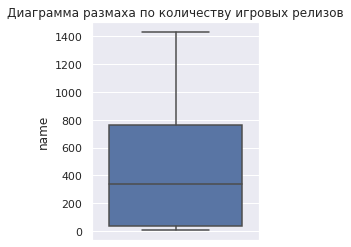

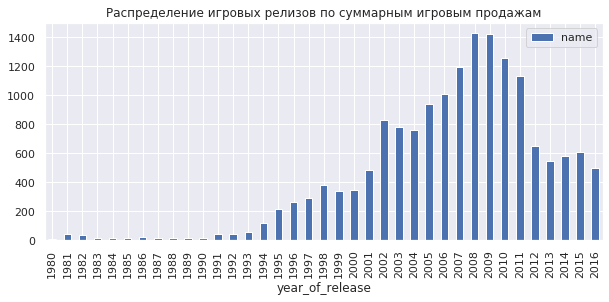

In [19]:
fig = plt.figure(figsize=(3, 4))
sns.set()
sns.boxplot(y='name', data=df_count_games_by_year).set_title("Диаграмма размаха по количеству игровых релизов")
df_count_games_by_year.plot(x='year_of_release', 
                            y='name', kind='bar', 
                            figsize=(10, 4)).set_title("Распределение игровых релизов по суммарным игровым продажам")
plt.show()

**Посмотрим, как менялись продажи по платформам.**

Выберем платформы с наибольшими суммарными продажами:

In [20]:
df_max_sales_per_platform = df.groupby('platform')['all_reg_sales'].sum().sort_values(ascending=False)
print(df_max_sales_per_platform)

platform
PS2     1247.28
X360     961.30
PS3      928.78
Wii      891.18
DS       802.79
PS       727.58
PS4      314.14
GBA      312.88
PSP      290.34
3DS      257.81
PC       256.11
GB       254.43
XB       252.66
NES      251.05
N64      218.01
SNES     200.04
GC       197.03
XOne     159.32
2600      86.48
WiiU      82.19
PSV       53.81
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: all_reg_sales, dtype: float64


Самой массовой платформой является PS2. Для пробы построим распределение по годам для нее, подобрав опытным путем значение bins, чтобы не возникало разрывом между столбцами:

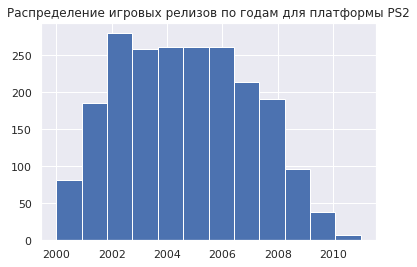

In [21]:
df_ps2 = df.query('platform == "PS2"')
df_ps2_hist = df_ps2['year_of_release']
df_ps2_hist.hist(bins=12)
plt.title("Распределение игровых релизов по годам для платформы PS2");

Как видим из гистограммы, жизненный цикл для данной платформы составляет около 10 лет. Далее проверим распределение для других массовых платформ по годам, возьмем седьмое поколение. Продажи для платформы DS очень высоки и для целей данной гистограммы не важны, поэтому ограничим значения по оси y для отображения более крупного масштаба. Значения для оси x определим опытным путем:

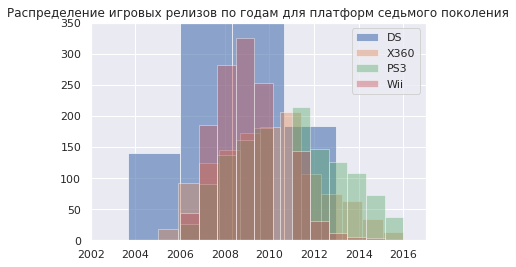

In [22]:
plt.xlim(2002, 2017)
plt.ylim(0, 350)
df_DS = df.query('platform == "DS"')
df_DS_hist = df_DS['year_of_release']
df_DS_hist.hist(bins=12, alpha=0.6)
df_x360 = df.query('platform == "X360"')
df_x360_hist = df_x360['year_of_release']
df_x360_hist.hist(bins=12, alpha=0.4)
df_PS3 = df.query('platform == "PS3"')
df_PS3_hist = df_PS3['year_of_release']
df_PS3_hist.hist(bins=12, alpha=0.4)
df_Wii = df.query('platform == "Wii"')
df_Wii_hist = df_Wii['year_of_release']
df_Wii_hist.hist(bins=12, alpha=0.4)
labels= ["DS","X360", "PS3", "Wii"]
plt.legend(labels)
plt.title("Распределение игровых релизов по годам для платформ седьмого поколения");

**Как видим, примерный срок существования платформ составляет также около 10 лет**

Для следующего этапа потребуется выбрать данные за соответствующий актуальный период. Кажется разумным выбрать последнее поколение (XOne, PS4, PC). На данном этапе консоли перестали быть своего рода элитарным устройством и появились во многих домохозяйствах. Ограничим распределение данных платформ периодом, начиная с 2013 года:

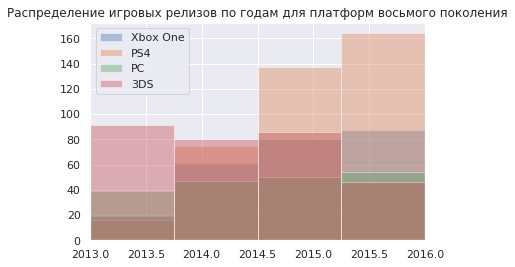

In [23]:
plt.xlim(2013, 2016)
df_xo = df.query('platform == "XOne" and year_of_release >=2013')
df_xo_hist = df_xo['year_of_release']
df_xo_hist.hist(bins=4, alpha=0.4)
df_ps4 = df.query('platform == "PS4" and year_of_release >=2013')
df_ps4_hist = df_ps4['year_of_release']
df_ps4_hist.hist(bins=4, alpha=0.4)
df_pc = df.query('platform == "PC" and year_of_release >=2013')
df_pc_hist = df_pc['year_of_release']
df_pc_hist.hist(bins=4, alpha=0.4)
df_3ds = df.query('platform == "3DS" and year_of_release >=2013')
df_3ds_hist = df_3ds['year_of_release']
df_3ds_hist.hist(bins=4, alpha=0.4)

labels= ["Xbox One","PS4", "PC", "3DS"]
plt.legend(labels)
plt.title("Распределение игровых релизов по годам для платформ восьмого поколения");

Как видим, продажи игр для ПК остаются примерно на одном уровне, а продажи игр для консолей растут, особенно, продажи игр для PS4. Но так как продажи консольных игр в 2013 году, в первом году выхода, были невысоки, за исключением 3DS, отсеем эти значения. Наша таблица будет начинаться с 2014 года:

In [24]:
df_working = df.query('year_of_release >= 2014')
df_working.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,all_reg_sales,critic_score,user_score,rating
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,14.63,NaN,NaN,NR
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,12.62,97.0,8.3,M
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,11.68,NaN,NaN,NR
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,8.58,82.0,4.3,E
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,7.98,NaN,NaN,NR


**Теперь посмотрим на соотношение продаж по платформам данного поколения:**

In [25]:
print(df_working.groupby('platform')['all_reg_sales'].sum().sort_values(ascending=False))

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
WiiU     42.98
PC       27.05
PSV      22.40
Wii       5.07
PSP       0.36
Name: all_reg_sales, dtype: float64


Как мы видим, в этот период еще есть остатки старого поколения, но так как оно начинает угасать, игр для него производится все меньше, это поколение нас не интересует. Будет логичным ограничить набор данных консолями Xbox One, PS4, PC, 3DS.

Построим тепловую карту значений:

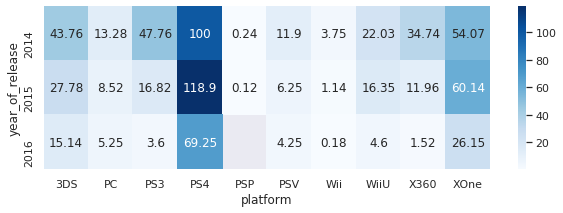

In [26]:
import seaborn as sns
platform_sales_pivot = df.query('year_of_release >= 2014').pivot_table(index = 'year_of_release', columns = 'platform', 
                  values = 'all_reg_sales', aggfunc = 'sum')

plt.figure(figsize = (10, 3))
sns.heatmap(platform_sales_pivot, annot = True, fmt='.4g', cmap = "Blues")
plt.show()

In [27]:
df_working = df_working.query('platform == "XOne" or  platform == "PS4" or  platform == "PC" or  platform == "3DS"')
df_working.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,all_reg_sales,critic_score,user_score,rating
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,14.63,NaN,NaN,NR
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,12.62,97.0,8.3,M
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,11.68,NaN,NaN,NR
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,8.58,82.0,4.3,E
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,7.98,NaN,NaN,NR


In [28]:
#проверка, что запрос сработал:
print(df_working['year_of_release'].unique())
print(df_working['platform'].unique())

[2015 2014 2016]
['PS4' '3DS' 'XOne' 'PC']


**Построим диаграммы размаха по глобальным продажам игр в разбивке по платформам:**

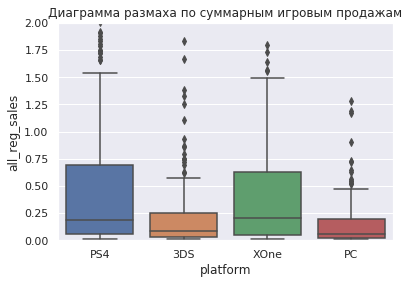

In [29]:
df_boxplot = df_working[['platform','all_reg_sales']]
sns.set()
plt.ylim(0, 2)
sns.boxplot(x='platform', y='all_reg_sales', data=df_boxplot).set_title("Диаграмма размаха по суммарным игровым продажам");

**Вывод**

Несмотря на то, что на платформах имеются однозначно хитовые игры с многомиллионными продажами (допустим, Call of Duty), эти игры входят в выбросы, основная масса не набирает в продажах и 1 миллиона, а медиана даже ниже 0,5 млн.

Такие критерии для выборки будем считать финальными.

**`На примере консоли PS4 посмотрим, как влияют отзывы пользователей и критиков на продажи внутри одной популярной платформы.`**

**Построим диаграмму рассеяния**

In [33]:
df_ps4 = df_working.query('platform == "PS4"')

Проверим на одной диаграмме соотношение с оценками игроков и оценками профессиональных критиков. Необходимо учитывать,ч то оценки критиков измеряются в десятках, поэтому для более точного совпадения разделим эти оценки на 10:

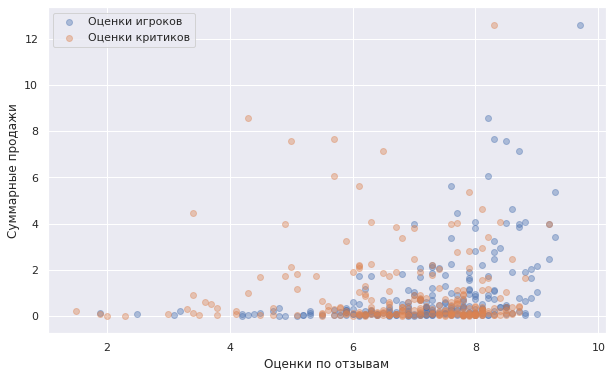

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = df_ps4['critic_score']/10, y = df_ps4['all_reg_sales'], alpha=0.4)
ax.scatter(x = df_ps4['user_score'], y = df_ps4['all_reg_sales'], alpha=0.4)
plt.xlabel("Оценки по отзывам")
plt.ylabel("Суммарные продажи")
labels= ["Оценки игроков","Оценки критиков"]
ax.legend(labels)
plt.show()

По диаграмме нельзя однозначно о наличии связи между оценками и продажами. Такой вывод более справедлив для хитовых игр с многомиллионными продажами, но таких игр не очень много. Встречаются также и игры с огромными продажами, но довольно скромными оценками.

**Посчитаем корреляцию:**

In [35]:
(df_ps4[['all_reg_sales', 'critic_score', 'user_score']]
.corr()['all_reg_sales']
.to_frame()
.sort_values('all_reg_sales', ascending=False)
.style
.background_gradient(cmap="Greens"))

,all_reg_sales
all_reg_sales,1
critic_score,0.402661
user_score,-0.0401316


Как видим, корреляция между оценками пользователей и продажами отсутствует

**Проверим корреляцию по продажам игр на других платформах (PS3, Wii, DS):**

In [36]:
df_xo = df_working.query('platform == "XOne"')
(df_xo[['all_reg_sales', 'critic_score', 'user_score']]
.corr()['all_reg_sales']
.to_frame()
.sort_values('all_reg_sales', ascending=False)
.style
.background_gradient(cmap="Greens"))

,all_reg_sales
all_reg_sales,1
critic_score,0.428677
user_score,-0.0703839


In [37]:
df_pc = df_working.query('platform == "PC"')
(df_pc[['all_reg_sales', 'critic_score', 'user_score']]
.corr()['all_reg_sales']
.to_frame()
.sort_values('all_reg_sales', ascending=False)
.style
.background_gradient(cmap="Greens"))

,all_reg_sales
all_reg_sales,1
critic_score,0.174634
user_score,-0.0715967


In [38]:
df_3ds = df_working.query('platform == "3DS"')
(df_3ds[['all_reg_sales', 'critic_score', 'user_score']]
.corr()['all_reg_sales']
.to_frame()
.sort_values('all_reg_sales', ascending=False)
.style
.background_gradient(cmap="Greens"))

,all_reg_sales
all_reg_sales,1
critic_score,0.314117
user_score,0.215193


**Напрашиваются следующие выводы:** 
- у платформы Xbox и у ПК корреляция отрицательная и при этом очень близка;
- продажи игр для всех платформ слабо коррелируют с пользовательскими оценками;
- в целом, на примере указанных платформ, можно сказать, что продажи не зависят от пользовательских оценок.

**Посмотрим на общее суммарное распределение игр по жанрам.**

In [39]:
df_genres = df_working[['genre','all_reg_sales','name']]
df_genres_sales = df_genres.groupby('genre',as_index=False)['all_reg_sales'].sum()
df_genres_count = df_genres.groupby('genre',as_index=False)['name'].count()

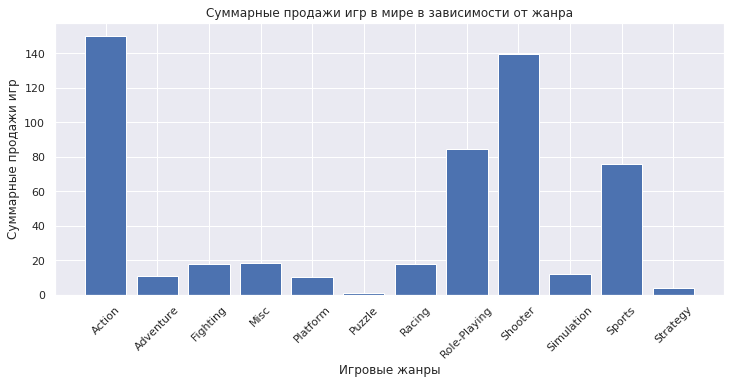

In [40]:
fig = plt.figure(figsize = (12, 5))
plt.bar(df_genres_sales['genre'], df_genres_sales['all_reg_sales'])
 
plt.xlabel("Игровые жанры")
plt.xticks(rotation=45)
plt.ylabel("Суммарные продажи игр")
plt.title("Суммарные продажи игр в мире в зависимости от жанра")
plt.show()

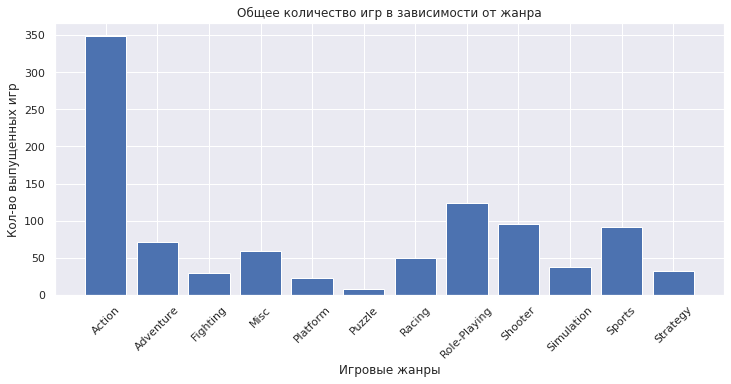

In [41]:
fig = plt.figure(figsize = (12, 5))
plt.bar(df_genres_count['genre'], df_genres_count['name'])
 
plt.xlabel("Игровые жанры")
plt.xticks(rotation=45)
plt.ylabel("Кол-во выпущенных игр")
plt.title("Общее количество игр в зависимости от жанра")
plt.show()

Распределение по продажам таково, что игры жанра Action на первом месте в обоих рейтингах. Но приносит ли она больше всех денег?

Заметно, что игры жанра "шутер" продаются сходными тиражами при меньшем количестве выпускаемых игры, значит в сравнении шутеры приносят больше денег. Можно сказать, что это справедливо и для игр в жанре РПГ и "спорт".

Самые низкоприбыльные жанры: Puzzle, Strategy.

**Посмотрим на общее медианное распределение игр по жанрам.**

In [42]:
df_genres = df_working[['genre','all_reg_sales','name']]
df_genres_sales = df_genres.groupby('genre',as_index=False)['all_reg_sales'].median()
df_genres_count = df_genres.groupby('genre',as_index=False)['name'].count()

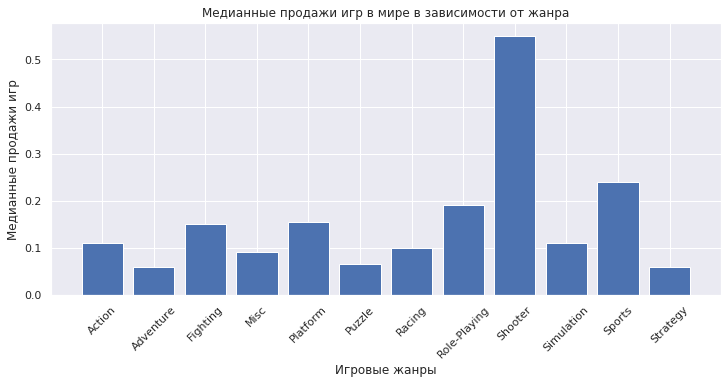

In [43]:
fig = plt.figure(figsize = (12, 5))
plt.bar(df_genres_sales['genre'], df_genres_sales['all_reg_sales'])
 
plt.xlabel("Игровые жанры")
plt.xticks(rotation=45)
plt.ylabel("Медианные продажи игр")
plt.title("Медианные продажи игр в мире в зависимости от жанра")
plt.show()

В данном случае картина изменилась: 
- игры жанра "шутер" приносят большее количество продаж.
- на втором месте игры жанра "спорт" и далее игры жанра РПГ;
- игры жанра "Action" уже не выглядят такими многообещающими.

**Общие выводы по разделу:** <a class="anchor" id="third-zero-bullet"></a>
- В списке игр присутствуют игры с 1980 года выпуска и множества платформ;
- Для актуального анализа файл был сокращен до четырех основных платформ: Xbox One, PS4, PC, 3DS, что соответствует восьмому поколению, годы выпуска ограничены периодом с 2014 по 2016 годы;
- Была изучена корреляция общего количества продаж игр и оценок критиков / пользователей. Обнаружилось, что корреляция этих факторов отсутствует. То есть, реальному покупателю оценки не особо важны;
- Были обнаружены самые прибыльные жанры: Shooter, Sports, RPG. Самые низкоприбыльные жанры: Puzzle, Strategy.

# 4. Составление портрета пользователя <a class="anchor" id="fourth-bullet"></a>

**Самые популярные платформы по регионам**

In [44]:
df_working.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,all_reg_sales,critic_score,user_score,rating
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,14.63,NaN,NaN,NR
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,12.62,97.0,8.3,M
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,11.68,NaN,NaN,NR
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,8.58,82.0,4.3,E
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,7.98,NaN,NaN,NR


**Регион NA:**

Самые популярные платформы (топ-5). Выведем данные сначала в табличном виде:

In [45]:
df_na_share = df_working.pivot_table(index=['platform'], 
                       values=['na_sales', 'all_reg_sales'], 
                       aggfunc={'na_sales' : 'sum', 'all_reg_sales' : 'sum'}).sort_values(by='platform', ascending=False)

df_na_share['share'] = round(df_na_share['na_sales'] / df_na_share['all_reg_sales'] * 100,2)
df_na_share.head()

,all_reg_sales,na_sales,share
platform,,,
XOne,140.36,81.27,57.90
PS4,288.15,98.61,34.22
PC,27.05,7.23,26.73
3DS,86.68,22.64,26.12


Теперь для наглядности построим столбчатую диаграмму:

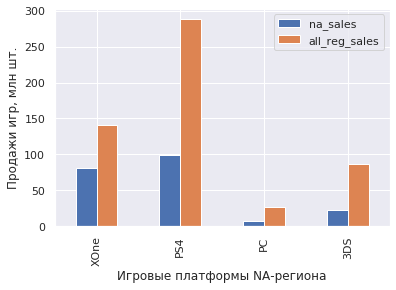

In [46]:
df_na_share[['na_sales', 'all_reg_sales']].plot(kind='bar', stacked=False)
plt.xlabel("Игровые платформы NA-региона")
plt.ylabel("Продажи игр, млн шт.");

Можно сделать несколько выводов:

- продажи игр по платформам Xbox One и PS4 на американском рынке примерно равны, но на глобальном рынке PS4 лидирует с большим отрывом;
- Продажи игр для 3DS малы, а продажи игр для ПК еще ниже - это и понятно, в Америке любят консоли, а кроме того, игыр на ПК покупают преимущественно в электронном виде.

**Регион EU:**

Самые популярные платформы (топ-5). Выведем данные сначала в табличном виде:

In [47]:
df_eu_share = df_working.pivot_table(index=['platform'], 
                       values=['eu_sales', 'all_reg_sales'], 
                       aggfunc={'eu_sales' : 'sum', 'all_reg_sales' : 'sum'}).sort_values(by='platform', ascending=False)

df_eu_share['share'] = round(df_eu_share['eu_sales'] / df_eu_share['all_reg_sales'] * 100,2)
df_eu_share.head()

,all_reg_sales,eu_sales,share
platform,,,
XOne,140.36,46.25,32.95
PS4,288.15,130.04,45.13
PC,27.05,17.97,66.43
3DS,86.68,16.12,18.60


Теперь для наглядности построим столбчатую диаграмму:

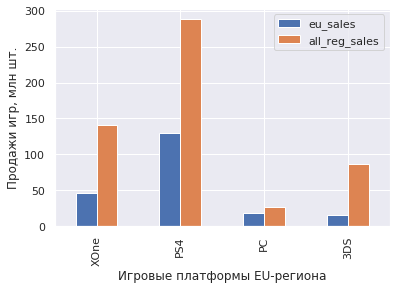

In [48]:
df_eu_share[['eu_sales', 'all_reg_sales']].plot(kind='bar', stacked=False)
plt.xlabel("Игровые платформы EU-региона")
plt.ylabel("Продажи игр, млн шт.");

Можно сделать несколько выводов:
- продажи Xbox в Европе значительно ниже, чем на американском рынке, и значительно ниже, чем продажи PS4;
- продажи игр для PS4 значительно лидируют;
- картинка для 3DS / ПК остается такой же.

**Регион JP:**

Самые популярные платформы (топ-5). Выведем данные сначала в табличном виде:

In [49]:
df_jp_share = df_working.pivot_table(index=['platform'], 
                       values=['jp_sales', 'all_reg_sales'], 
                       aggfunc={'jp_sales' : 'sum', 'all_reg_sales' : 'sum'}).sort_values(by='platform', ascending=False)

df_jp_share['share'] = round(df_jp_share['jp_sales'] / df_jp_share['all_reg_sales'] * 100,2)
df_jp_share.head()

,all_reg_sales,jp_sales,share
platform,,,
XOne,140.36,0.32,0.23
PS4,288.15,15.02,5.21
PC,27.05,0.00,0.00
3DS,86.68,44.24,51.04


Теперь для наглядности построим столбчатую диаграмму:

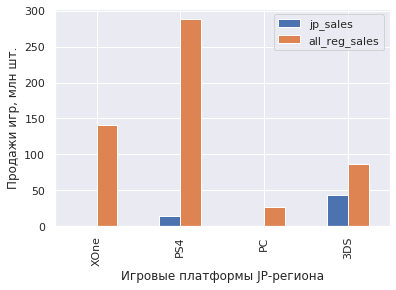

In [50]:
df_jp_share[['jp_sales', 'all_reg_sales']].plot(kind='bar', stacked=False)
plt.xlabel("Игровые платформы JP-региона")
plt.ylabel("Продажи игр, млн шт.");

Можно сделать несколько выводов:
- низкая доля продаж по всем платформам от общемировых продаж - японцев не особо интересуют мировые хиты;
- продажи игр для Xbox и ПК отсутствуют;
- консоли 3DS / PS4 - самые популярные.

**Самые популярные жанры по регионам**

**Регион NA:**

Самые популярные жанры (топ-5). Выведем данные сначала в табличном виде:

In [51]:
df_na_share = df_working.pivot_table(index=['genre'], 
                       values=['na_sales', 'all_reg_sales'], 
                       aggfunc={'na_sales' : 'sum', 'all_reg_sales' : 'sum'}).sort_values(by='genre', ascending=False)

df_na_share['share'] = round(df_na_share['na_sales'] / df_na_share['all_reg_sales'] * 100,2)
df_na_share.head()

,all_reg_sales,na_sales,share
genre,,,
Strategy,3.72,0.98,26.34
Sports,75.94,31.49,41.47
Simulation,12.28,2.26,18.40
Shooter,139.64,64.24,46.00
Role-Playing,84.43,28.49,33.74


Теперь для наглядности построим столбчатую диаграмму:

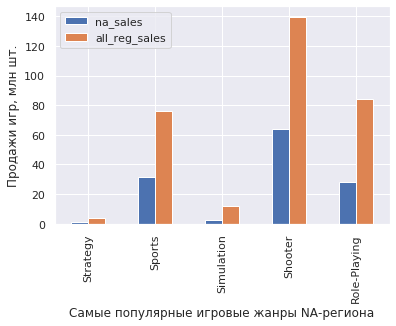

In [52]:
df_na_share[['na_sales', 'all_reg_sales']].head().plot(kind='bar', stacked=False)
plt.xlabel("Самые популярные игровые жанры NA-региона")
plt.ylabel("Продажи игр, млн шт.");

Можно сделать несколько выводов:
- Самый популярный жанр в североамериканском регионе - шутер;
- На вторых местах спортивные игры и РПГ;
- Похожий тренд и на глобальном рынке;
- Игры-симуляторы хоть и входят в распределение, но продажи минимальны.

**Регион EU:**

Самые популярные жанры (топ-5). Выведем данные сначала в табличном виде:

In [53]:
df_eu_share = df_working.pivot_table(index=['genre'], 
                       values=['eu_sales', 'all_reg_sales'], 
                       aggfunc={'eu_sales' : 'sum', 'all_reg_sales' : 'sum'}).sort_values(by='genre', ascending=False)

df_eu_share['share'] = round(df_eu_share['eu_sales'] / df_eu_share['all_reg_sales'] * 100,2)
df_eu_share.head()

,all_reg_sales,eu_sales,share
genre,,,
Strategy,3.72,1.79,48.12
Sports,75.94,32.78,43.17
Simulation,12.28,6.97,56.76
Shooter,139.64,54.79,39.24
Role-Playing,84.43,24.97,29.57


Теперь для наглядности построим столбчатую диаграмму:

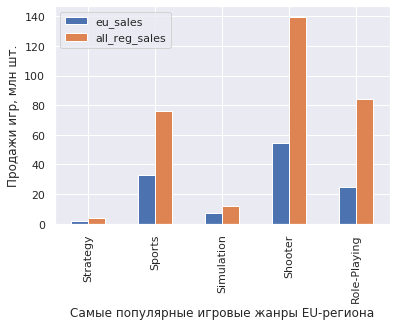

In [54]:
df_eu_share[['eu_sales', 'all_reg_sales']].head().plot(kind='bar', stacked=False)
plt.xlabel("Самые популярные игровые жанры EU-региона")
plt.ylabel("Продажи игр, млн шт.");

Можно сделать вывод:
- Шутеры и тут на первом месте, спорт и РПГ занимают равные доли;
- В целом продажи ниже, чем в североамериканском регионе.

**Регион JP:**

Самые популярные платформы (топ-5). Выведем данные сначала в табличном виде:

In [55]:
df_jp_share = df_working.pivot_table(index=['genre'], 
                       values=['jp_sales', 'all_reg_sales'], 
                       aggfunc={'jp_sales' : 'sum', 'all_reg_sales' : 'sum'}).sort_values(by='genre', ascending=False)

df_jp_share['share'] = round(df_jp_share['jp_sales'] / df_jp_share['all_reg_sales'] * 100,2)
df_jp_share.head()

,all_reg_sales,jp_sales,share
genre,,,
Strategy,3.72,0.71,19.09
Sports,75.94,1.44,1.90
Simulation,12.28,2.25,18.32
Shooter,139.64,2.67,1.91
Role-Playing,84.43,23.75,28.13


Теперь для наглядности построим столбчатую диаграмму:

Text(0, 0.5, 'Продажи игр, млн шт.')

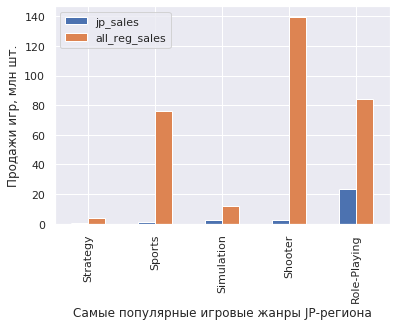

In [56]:
df_jp_share[['jp_sales', 'all_reg_sales']].head().plot(kind='bar', stacked=False)
plt.xlabel("Самые популярные игровые жанры JP-региона")
plt.ylabel("Продажи игр, млн шт.")

Можно сделать вывод:
- Японцы любят РПГ, а продажи хитовых игр в сравнении с мировым рынком очень малы.

**Влияет ли рейтинг ESRB на продажи в отдельном регионе?**

Построим круговые диаграммы:

**Регион NA:**

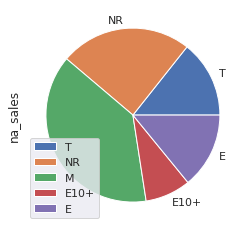

In [57]:
df_na_pie = df_working.pivot_table(index=['rating'], 
                       values=['na_sales'], 
                       aggfunc={'na_sales' : 'sum'}).sort_values(by='rating', ascending=False)
df_na_pie.plot.pie(subplots=True, figsize=(8, 4));

**Регион EU:**

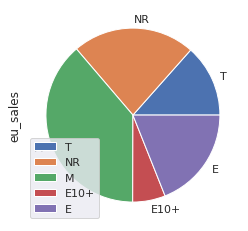

In [58]:
df_eu_pie = df_working.pivot_table(index=['rating'], 
                       values=['eu_sales'], 
                       aggfunc={'eu_sales' : 'sum'}).sort_values(by='rating', ascending=False)
df_eu_pie.plot.pie(subplots=True, figsize=(8, 4));

**Регион JP:**

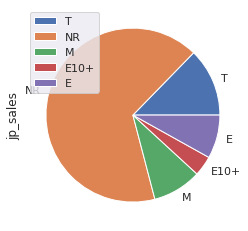

In [59]:
df_jp_pie = df_working.pivot_table(index=['rating'], 
                       values=['jp_sales'], 
                       aggfunc={'jp_sales' : 'sum'}).sort_values(by='rating', ascending=False)
df_jp_pie.plot.pie(subplots=True, figsize=(8, 4));

Можно сделать вывод:
- Как видим, доли продаж по возрастному рейтингу примерно одинаковы в случае североамериканского и европейского рынков;
- По продажам наиболее массовы игры возрастной категории M: публика сильно повзрослела, как и контент (вспомним прошлое поколение, где лидировали игры рейтинга Е);
- Самая высокая доля игр NOT RATED в Японии - возможно потому, что рейтинги для внутренного рынка Японии имеют меньшую важность или не подчиняются рейтингу ESRB.

**Общие выводы по разделу:** <a class="anchor" id="fourth-zero-bullet"></a>
- На общемировом рынке позиции PS4 сильно лидирует;
- В североамериканском регионе продажи игр для Xbox One и PS4 примерно равны, а в европейском регионе PS4 заметно обгоняет Xbox по продажам;
- Продажи игр в Японии довольно низки, за исключением РПГ, из платформ живы только 3DS и PS4;
- Рынок игр для ПК слаб во всем мире;
- Распределени игр по популярным жанрам одинаково во всех регионах: на первом месте шутеры, на втором спортивные игры, и на третьем месте РПГ. Стратегии и паззлы уже довольно нишевые жанры;
- Если смотреть по возрастному рейтингу, то основную долю продаж делают игры рейтинга M. Для Японии рейтинги менее важны, там продаются игры без рейтинга.

# 5. Проверка гипотез <a class="anchor" id="fifth-bullet"></a>

**Сформулируем нулевую и альтернативную гипотезы для первого случая:**

- H<sub>0</sub>: Средние пользовательские рейтинги платформ Xbox One и ПК одинаковые;
- H<sub>1</sub>: Средние пользовательские рейтинги платформ Xbox One и ПК не одинаковые.

Сделаем выборку:

In [60]:
df_xo_score = df_working[df_working['platform']=='XOne']['user_score']
df_xo_score = df_xo_score.dropna(axis=0)

df_pc_score = df_working[df_working['platform']=='PC']['user_score']
df_pc_score = df_pc_score.dropna(axis=0)

Построим гистограммы:

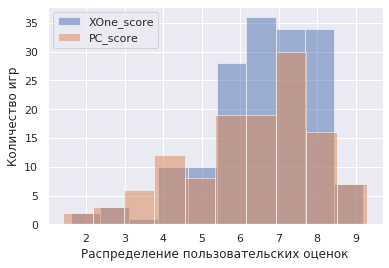

In [61]:
plt.hist(df_xo_score, bins=10, alpha=0.5, label='XOne_score')
plt.hist(df_pc_score, bins=10, alpha=0.5, label='PC_score')
plt.xlabel('Распределение пользовательских оценок')
plt.ylabel('Количество игр')
plt.legend(loc='upper left')
plt.show()

Проверим нормальность распределения наших выборок методом Шапиро-Уилка:

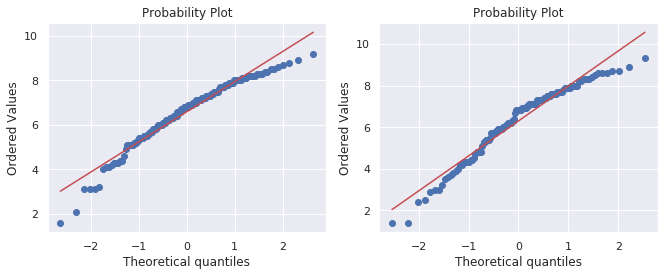

In [62]:
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(131)
st.probplot(df_xo_score, dist="norm", plot=plt)

ax2 = fig.add_subplot(132)
st.probplot(df_pc_score, dist="norm", plot=plt)

fig.tight_layout()
plt.show()

Как видим, распределение не совсем нормальное. 
    
По условиям проверки нам надо сравнить среднюю пользовательскую оценку. Для этого можно использовать тест Стьюдента. Уровень значимости определим равным 0,05.

In [63]:
alpha = 0.05

results = st.ttest_ind(df_xo_score, df_pc_score) 

print('Тест Стьюдента, p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Тест Стьюдента, p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


**Вывод:**
По результатам обоих тестов мы можем склониться к тому, чтобы поддержать нулевую гипотезу, т.е. средние пользовательские рейтинги игр для Xbox One и ПК не будут различаться.

**Сформулируем нулевую и альтернативную гипотезы для второго случая:**

- H<sub>0</sub>: Средние пользовательские рейтинги жанров Action и Sports одинаковые;
- H<sub>1</sub>: Средние пользовательские рейтинги жанров Action и Sports не одинаковые.

Сделаем выборку:

In [64]:
df_action_score = df_working[df_working['genre']=='Action']['user_score']
df_action_score = df_action_score.dropna(axis=0)

df_sports_score = df_working[df_working['genre']=='Sports']['user_score']
df_sports_score = df_sports_score.dropna(axis=0)

Построим гистограммы:

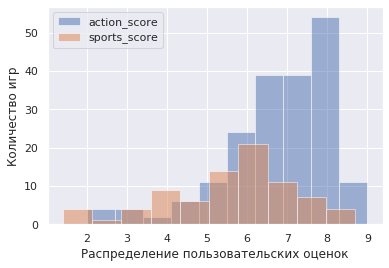

In [65]:
plt.hist(df_action_score, bins=10, alpha=0.5, label='action_score')
plt.hist(df_sports_score, bins=10, alpha=0.5, label='sports_score')
plt.xlabel('Распределение пользовательских оценок')
plt.ylabel('Количество игр')
plt.legend(loc='upper left')
plt.show()

Проверим нормальность распределения наших выборок методом Шапиро-Уилка:

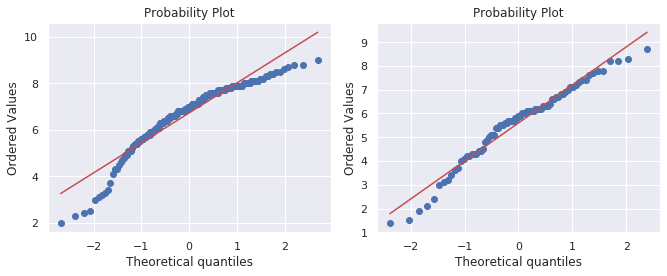

In [66]:
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(131)
st.probplot(df_action_score, dist="norm", plot=plt)

ax2 = fig.add_subplot(132)
st.probplot(df_sports_score, dist="norm", plot=plt)

fig.tight_layout()
plt.show()

Распределение близко к нормальному, но не является нормальным. Проверим дисперсию:

In [67]:
variance_action_score = np.var(df_action_score, ddof=1)
variance_sports_score = np.var(df_sports_score, ddof=1)
print("Дисперсия для action:",variance_action_score)
print("Дисперсия для sports:",variance_sports_score)

Дисперсия для action: 1.806583248758079
Дисперсия для sports: 2.5506234567901234


Как видим, дисперсия сильно различается. 
    
По условиям проверки нам надо сравнить среднюю пользовательскую оценку. Для этого можно использовать тест Стьюдента. Уровень значимости определим равным 0,05.

In [68]:
alpha = 0.05

results = st.ttest_ind(df_action_score, df_sports_score) 

print('Тест Стьюдента, p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Тест Стьюдента, p-значение: 5.856201190470744e-09
Отвергаем нулевую гипотезу


**Вывод:**

По результатам тестов мы можем склониться к тому, чтобы отвергнуть нулевую гипотезу. То есть, мы не нашли подтверждения, что пользовательские оценки в жанрах sports и action равны.

**Общие выводы по разделу:** <a class="anchor" id="fifth-zero-bullet"></a>
- В составе исследования мы проверили гипотезы о том, что средние пользовательские рейтинги платформ Xbox One и ПК одинаковые, а также о том, что пользовательские оценки в жанрах sports и action равны;
- У нас есть основания отклонить только вторую гипотезу.

# 6. Общий вывод <a class="anchor" id="sixth-bullet"></a>

Нами проведено исследование базы данных по продажам игр для нескольких поколений консолей в разных регионах мира. 

Для получения более эффективной модели пользователя игры были ограничены "хитами" (т.е. продажи составляют от 1 до 5 млн шт.), были исключены неперспективные для продаж консоли и оставлены платформы восьмого поколения Xbox One, PS4, 3DS, а также ПК;

В составе исследования были изучены данные по трем мировым рынкам: NA, EU, JP и сделаны следующие выводы:

- В североамериканском регионе игры для Xbox One и PS4 примерно равны по продажам, в европейском регионе безусловно лидируют игры для PS4;
- Рынок Японии для мировых хитов очень мал;
- PS4 лидирует по абсолютным объемам продаж игр в мире, на втором месте Xbox One;
- Распределение по самым популярным жанрам выглядит так: 1) Shooters 2) Sports 3) PRGs;
- Больше всего продается игр с возрастным рейтингом M (Mature);

Мы сформулировали гипотезы о том, что:

- Средние пользовательские рейтинги платформ Xbox One и ПК одинаковые;
- Средние пользовательские рейтинги жанров Action и Sports одинаковые

У нас появились основания отклонить только вторую гипотезу, т.е. разницу в предпочтения аудитории для достижения максимальных продаж **необходимо** учитывать.